# LOWESS filtering


A wrapper needs to be written to accept pandas object and make sure input time is sorted

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from numba import njit, guvectorize, int32, float64, prange

In [2]:
nt = 1000
df = pd.DataFrame(dict(time= np.random.normal(size=nt)/2 + np.arange(nt)))
df["x"] = np.sin(df["time"]*10/nt)*100 + np.random.normal(size=nt)
df = df.sort_values("time")

<AxesSubplot: xlabel='time'>

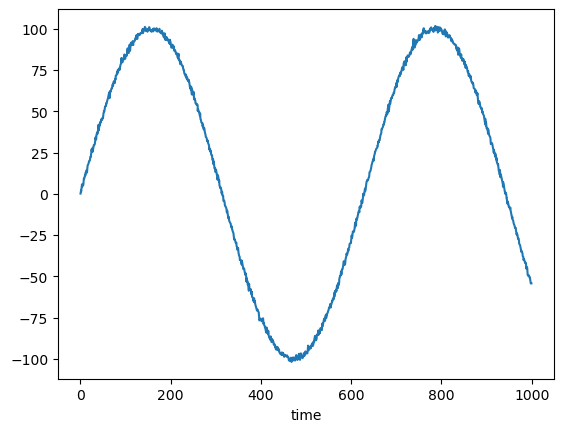

In [3]:
df.set_index("time").x.plot()

<AxesSubplot: ylabel='Frequency'>

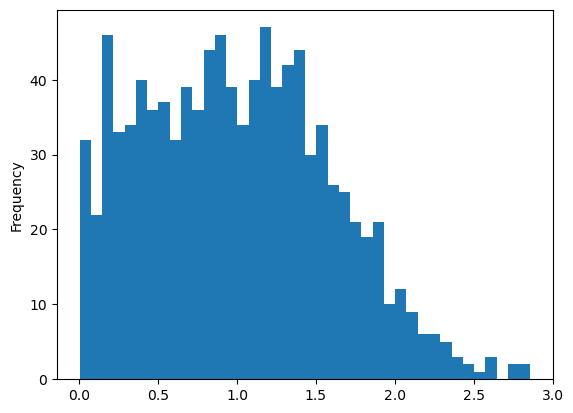

In [4]:
df["dt"] = df.time.diff()
df.set_index("time")["dt"].plot.hist(bins=40)

In [11]:
@njit
def advance_search(nt, time, t, i, delta_plus, delta_minus):
    """ find next closest neighbourgh by searching in positive and negative 
    directions with respect to index i
    """
    # delta=0 means search as stopped in that direction
    #  compute distances with i+delta_plus and i+delta_minus points
    if delta_plus>0 and i+delta_plus<nt:
        d_plus = abs(time[i+delta_plus]-t)
    else:
        d_plus = -1.
    if delta_minus<0 and i+delta_minus>=0:
        d_minus = abs(time[i+delta_minus]-t)
    else:
        d_minus = -1.
    # update delta_plus or delta_minus
    if d_minus!=-1 and (d_plus==-1 or d_minus<d_plus):
        i_next = i+delta_minus
        if i+delta_minus>0:
            delta_minus+=-1
        else:
            # stop search in that direction
            delta_minus=0
    elif d_plus!=-1 and (d_minus==-1 or d_minus>d_plus):
        i_next = i+delta_plus
        if i+delta_plus<nt-1:
            delta_plus+=1
        else:
            # stop search in that direction
            delta_plus=0
    else:  # nope (numba '0.56.3')
        print(('pb advance search', i, delta_minus, delta_plus, d_minus, d_plus))
    #    # should never reach this point
    #    #assert False, (i, delta_minus, delta_plus, d_minus, d_plus)
    #    # AssertionError: (998, -1, 0, 0.9963861521472381, -1.0)
    return i_next, delta_minus, delta_plus
    
@njit
def find_nearest_neighboors(time, t, i):
    """ Find 3 remaining neighbouring points
    i is a starting value (closest point)
    """
    nt = len(time)
    nb = 4
    ib = [0 for _ in range(nb)]
    ib[0] = i
    if i==nt:
        delta_plus=0
    else:
        delta_plus=1
    if i==0:
        delta_minus=0
    else:
        delta_minus=-1
    counter = 1
    while counter<nb:
        ib[counter], delta_minus, delta_plus = advance_search(nt, time, t, i, delta_plus, delta_minus)    
        counter+=1
    return np.sort(np.array(ib))

#@guvectorize([(float64[:], float64[:])], '(n)->(n)')
#@guvectorize(["void(float64[:], float64[:])"], '(n)->(n)')
# guvectorize cannot be called from a jit method at the moment, see: https://github.com/numba/numba/issues/5720
#def I_func(v, res):
@njit
def I_func(v):
    I = np.zeros_like(v)
    for i in range(v.shape[0]):
        if v[i]>-1 or v[i]<1:
            I[i] = v[i]
        else:
            I[i] = 0.
    return I

@njit
def solve_position_velocity(t_nb, x_nb, t_target):
    # solve for x and u :  x + u*(t_nb-t_target) = x_nb
    t = t_nb - t_target
    dt = t_nb[-1]-t_nb[0]
    weights = 70/81*(1-np.abs(t/dt)**3) * I_func( t/dt )
    w = np.sum(weights)
    wt = np.sum(weights * t)
    wt2 = np.sum(weights * t**2)
    A = np.array([[w,wt],[wt,wt2]])
    b = np.array([np.sum(weights*x_nb), np.sum(weights*x_nb*t)])
    out = np.linalg.solve(A, b)
    return out[0], out[1]

#@njit("UniTuple(float64[:], 2)(float64[:], float64[:], float64[:])")
@njit
def lowess(time, x, time_target):
    """ perform a lowess interpolation
    
    Parameters
    ----------
    time: np.array
        time array, assumed to be sorted in time, should be floats
    x: np.array
        positions
    time_target: np.array
        target timeline
    
    """
    nt = len(time_target)
    
    assert time_target[0]>=time[0], "time_target[0] is not within time span"
    assert time_target[-1]<=time[-1], "time_target[-1] is not within time span"
        
    # find closest values
    #d = np.abs(time[:,None] - time_target[None, :]) # nope (numba '0.56.3')
    d = np.abs(time.reshape(len(time), 1) - time_target.reshape(1, nt))
    i_closest = np.argmin(d, axis=0)
    
    x_out = np.zeros(nt)
    u_out = np.zeros(nt)
    for i in prange(nt):
        i_nb = find_nearest_neighboors(time, time_target[i], i_closest[i])
        t_nb = time[i_nb]
        x_nb = x[i_nb]
        x_out[i], u_out[i] = solve_position_velocity(t_nb, x_nb, time_target[i])
        
    return x_out, u_out

In [12]:
# need wrapper to extract numpy arrays and put them back in dataframe
time = df.time.values
time[0] = 0 # en
time_target = np.arange(100,None,2)*1.
x = df.x.values

x_out, u_out = lowess(time, x, time_target)

df_out = pd.DataFrame(dict(x=x_out, u=u_out, time=time_target))

In [10]:
time

array([  0.        ,   1.52997135,   1.79672925,   3.51146837,
         4.24273195,   4.54039652,   5.73014538,   6.54480045,
         7.71873631,   8.41188028,  10.63004578,  11.36529239,
        11.52334309,  13.64090349,  13.7517955 ,  14.65520044,
        16.02014855,  16.87935498,  18.71592581,  18.88544922,
        20.8349775 ,  21.19623486,  22.17069028,  23.40215079,
        23.43705419,  25.12391396,  25.3615321 ,  27.23863076,
        27.30314019,  28.53482953,  29.69729753,  30.83825037,
        31.96633211,  33.76118542,  33.8501703 ,  35.10280235,
        35.43694063,  37.2447693 ,  37.47337337,  38.79384349,
        40.30366526,  40.71048026,  42.30850305,  42.48855853,
        43.95085533,  45.16505581,  45.97182666,  46.91476399,
        48.2672343 ,  48.90676046,  50.05726899,  51.21530837,
        52.48342964,  52.80033502,  54.10497021,  54.73307397,
        56.79474016,  57.3715766 ,  57.75822617,  59.32112665,
        60.61167232,  60.94605166,  61.45419959,  63.81

In [9]:
numba.__version__

'0.56.3'

In [7]:
_df = df_out.set_index("time")

fig, axes = plt.subplots(2,1)

_df["x"].plot(ax=axes[0])
df.set_index("time")["x"].plot(ax=axes[0])

_df["u"].plot(ax=axes[1])


NameError: name 'df_out' is not defined